# 2025 CITS4012 Individual Assignment
*Make sure you change the file name with your student id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

Sorry the Code isn't super logical throughout, I don't have the time to do a full refactor at the moment, Jupyter is a blessing and a curse, it's super convenient to work with but rewards some awful coding practice, not all the imports are collated and some code is just copiied into a new cell rather than refactored. sorry in advance.



*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

In [141]:
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/jharvey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jharvey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [142]:
def remove_punc(text):
    """Remove punctuation and make lowercase."""
    normalized_text = []
    for string in text:
        tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
        normalized_text.append(tokens)
    return ''.join(normalized_text)

*Note: Decided not to structure by sentence for now.*

In [143]:
# TODO: Import data
with open('medical_tc_train.csv', 'r') as f:
    f = f.readlines()
    for index, line in enumerate(f):
        text_start = line.index(',')+1
        f[index] = line[:text_start] + remove_punc(line[text_start:])
    data = np.genfromtxt(f, delimiter=',', dtype=str, skip_header=1)
data = data.astype(object)
data[:,1] = [word_tokenize(text) for text in data[:,1]]
print(data[:3])

[['5'
  list(['tissue', 'changes', 'around', 'loose', 'prostheses', 'a', 'canine', 'model', 'to', 'investigate', 'the', 'effects', 'of', 'an', 'antiinflammatory', 'agent', 'the', 'aseptically', 'loosened', 'prosthesis', 'provided', 'a', 'means', 'for', 'investigating', 'the', 'in', 'vivo', 'and', 'in', 'vitro', 'activity', 'of', 'the', 'cells', 'associated', 'with', 'the', 'loosening', 'process', 'in', 'seven', 'dogs', 'the', 'cells', 'were', 'isolated', 'and', 'maintained', 'in', 'culture', 'for', 'sufficient', 'periods', 'of', 'time', 'so', 'that', 'their', 'biologic', 'activity', 'could', 'be', 'studied', 'as', 'well', 'as', 'the', 'effect', 'of', 'different', 'agents', 'added', 'to', 'the', 'cells', 'in', 'vivo', 'or', 'in', 'vitro', 'the', 'biologic', 'response', 'as', 'determined', 'by', 'interleukin', '1', 'and', 'prostaglandin', 'e2', 'activity', 'paralleled', 'the', 'roentgenographic', 'appearance', 'of', 'loosening', 'and', 'the', 'technetium', 'images', 'and', 'observations'

# 2.Word Embedding Construction
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Word Embedding Selection

For this embedding I selected SkipGram, over the alternatives, FastText and CBOW. After browsing the medical abstracts briefly I think there are some words that are more semantically context dependent, something SkipGram would identify well, a trade off in this is that words that share similar roots because of their association may be missed if not placed in context with one another due to language semantics of the english language and how sometimes we fully restructure sentences and word choice when changing tenses or contexts, this is something that FastText may be better for. As for why SkipGram and not CBOW, SkipGram is better at detecting broader context clues rather than CBOW's word to word relations, in the medical abstracts this may be important as they tend to be consice and subtle differences in context may drastically alter meaning.

In [144]:
from gensim.models import Word2Vec

# Using vector size of 200 for matching pretrained bwv
w2v_sg = Word2Vec(sentences=data[:,1], vector_size=200, window=5, min_count=1, sg=1)

In [145]:
similar_words = w2v_sg.wv.most_similar('hepatic', topn=10)
print(similar_words)

[('liver', 0.6734399199485779), ('cirrhosis', 0.5828890800476074), ('portal', 0.5738356113433838), ('hypersplenism', 0.5731666684150696), ('hepatocellular', 0.5411064624786377), ('ascites', 0.5349833965301514), ('extrahepatic', 0.5307225584983826), ('cholestasis', 0.5279385447502136), ('auxiliary', 0.5264267325401306), ('fulminant', 0.5238557457923889)]


In [146]:
print(f"w2v_sg shape: {w2v_sg.wv.vectors.shape}")
w2v_sg_vocab = w2v_sg.wv.key_to_index
print(f'Vocabulary size: {len(w2v_sg_vocab)}')
print(f'First 10 words in vocabulary: {list(w2v_sg_vocab)[:10]}')

w2v_sg shape: (35254, 200)
Vocabulary size: 35254
First 10 words in vocabulary: ['the', 'of', 'and', 'in', 'with', 'a', 'to', 'patients', 'was', 'were']


In [147]:
from gensim.models import keyedvectors

pretrained_bwv = keyedvectors.KeyedVectors.load_word2vec_format('./bio_embedding_extrinsic', binary=True)

In [148]:
print(f"pretrained bwv shape: {pretrained_bwv.vectors.shape}")
print(pretrained_bwv.most_similar('hepatic', topn=10))
pretrained_bwv_vocab = pretrained_bwv.key_to_index
print(f'Vocabulary size: {len(pretrained_bwv_vocab)}')
print(f'First 10 words in vocabulary: {list(pretrained_bwv_vocab)[:10]}')

pretrained bwv shape: (2324849, 200)
[('liver', 0.8543078899383545), ('sc-hepatic', 0.8127488493919373), ('post-hepatic', 0.803892970085144), ('ofhepatic', 0.8024373650550842), ('pre-hepatic', 0.7877070903778076), ('ahepatic', 0.7826353907585144), ('rat-hepatic', 0.7772555947303772), ('posthepatic', 0.776041567325592), ('extra-hepatic', 0.7705439329147339), ('steatosis', 0.7689445614814758)]
Vocabulary size: 2324849
First 10 words in vocabulary: ['the', 'of', 'and', 'in', 'to', 'a', 'with', 'for', 'was', 'were']


## Word index mapping from training dataset vocabulary

In [188]:
word_index = {word: idx+1 for idx, word in enumerate(sorted({w for doc in data[:,1] for w in doc}))}
pad_idx = 0

## Concatteration of SkipGram and BioWordVec

In [ ]:
sg_dim = w2v_sg.vector_size
bwv_dim = pretrained_bwv.vector_size
embedding_matrix = np.zeros((len(word_index)+1, sg_dim + bwv_dim))

for word, idx in word_index.items():
    sg_vec = w2v_sg.wv[word] if word in w2v_sg.wv else np.zeros(sg_dim)
    bwv_vec = pretrained_bwv[word] if word in pretrained_bwv else np.zeros(bwv_dim)
    embedding_matrix[idx] = np.concatenate([sg_vec, bwv_vec])



## BioWordVec -> Embedding Matrix

For use in BiRNN later

In [150]:
embedding_matrix_2 = np.zeros((len(word_index)+1, bwv_dim))
for word, idx in word_index.items():
    bwv_vec = pretrained_bwv[word] if word in pretrained_bwv else np.zeros(bwv_dim)
    embedding_matrix_2[idx] = bwv_vec

# 3.Visualization
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### Word List for Visualisation

In [190]:
WORD_LIST = ['patient', 'liver', 'renal', 'kidney', 'disease', 'cancer', 'tumor', 'cell', 'blood', 'therapy']

## Word2Vec SkipGram Graph

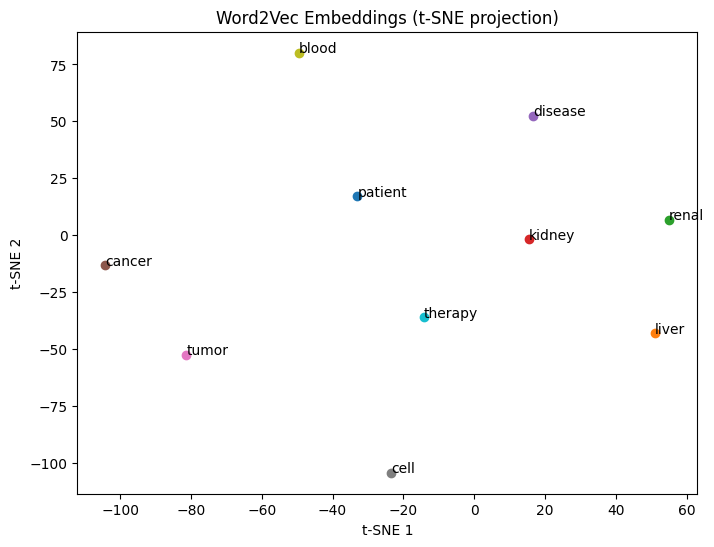

In [191]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = WORD_LIST

word_vectors = [w2v_sg.wv[word] for word in words if word in w2v_sg.wv]
word_vectors = np.array(word_vectors)

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vecs_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    if word in w2v_sg.wv:
        plt.scatter(vecs_2d[i, 0], vecs_2d[i, 1])
        plt.annotate(word, (vecs_2d[i, 0], vecs_2d[i, 1]))
plt.title("Word2Vec Embeddings (t-SNE projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

## BioWordVec Graph

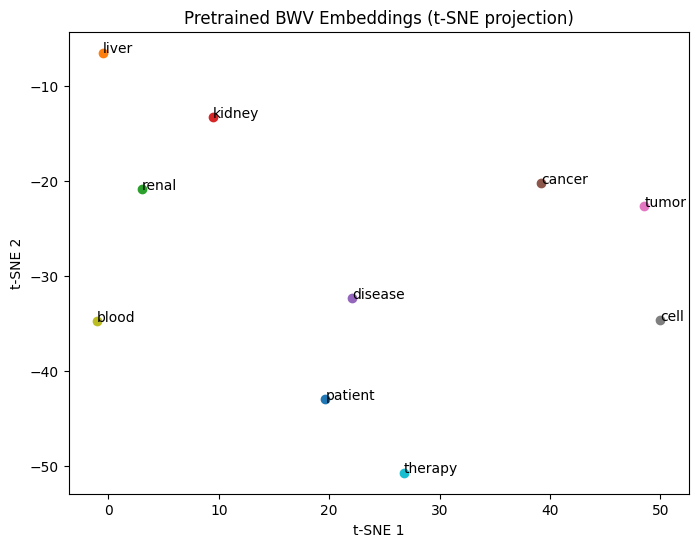

In [192]:
word_vectors = [pretrained_bwv[word] for word in words if word in pretrained_bwv]

# Convert to numpy for tsne input
word_vectors = np.array(word_vectors)

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vecs_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    if word in pretrained_bwv:
        plt.scatter(vecs_2d[i, 0], vecs_2d[i, 1])
        plt.annotate(word, (vecs_2d[i, 0], vecs_2d[i, 1]))
plt.title("Pretrained BWV Embeddings (t-SNE projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

## Concaterated sg + bwv Vectors Graph

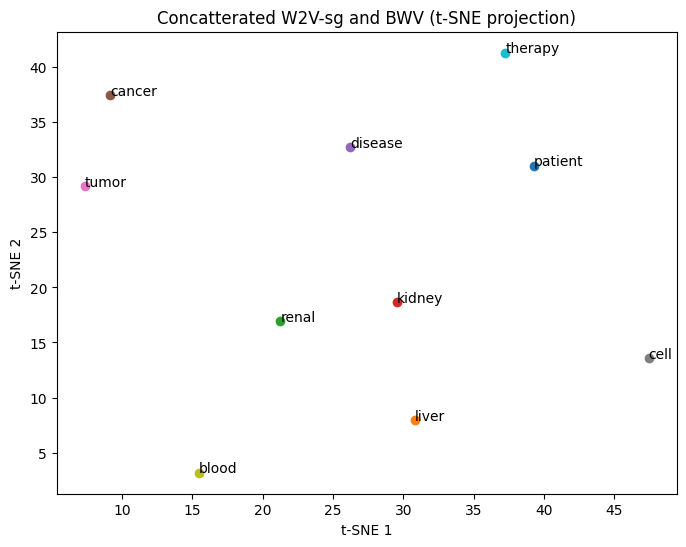

In [193]:
plot_words = [word for word in words if word in word_index]
word_vectors = np.array([embedding_matrix[word_index[word]] for word in plot_words])

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(plot_words)-1))
vecs_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, word in enumerate(plot_words):
    plt.scatter(vecs_2d[i, 0], vecs_2d[i, 1])
    plt.annotate(word, (vecs_2d[i, 0], vecs_2d[i, 1]))
plt.title("Concatterated W2V-sg and BWV (t-SNE projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()



## Side By Side Comparison

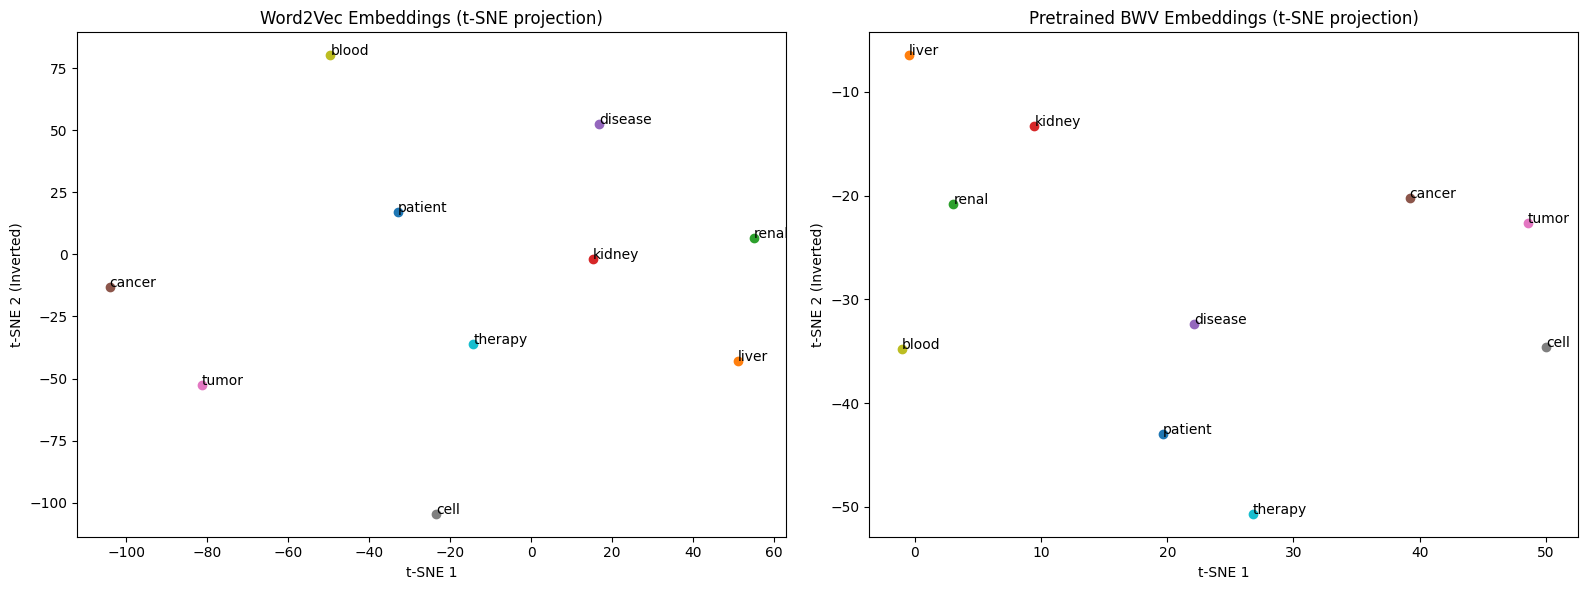

In [194]:
# Word2Vec model vectors
w2v_vectors = [w2v_sg.wv[word] for word in words if word in w2v_sg.wv]
w2v_vectors = np.array(w2v_vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
w2v_vecs_2d = tsne.fit_transform(w2v_vectors)

# Pretrained BWV vectors
bwv_vectors = [pretrained_bwv[word] for word in words if word in pretrained_bwv]
bwv_vectors = np.array(bwv_vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
bwv_vecs_2d = tsne.fit_transform(bwv_vectors)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word2Vec plot
axes[0].set_title("Word2Vec Embeddings (t-SNE projection)")
for i, word in enumerate(words):
    if word in w2v_sg.wv:
        axes[0].scatter(w2v_vecs_2d[i, 0], w2v_vecs_2d[i, 1])
        axes[0].annotate(word, (w2v_vecs_2d[i, 0], w2v_vecs_2d[i, 1]))
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2 (Inverted)")

# Pretrained BWV plot
axes[1].set_title("Pretrained BWV Embeddings (t-SNE projection)")
for i, word in enumerate(words):
    if word in pretrained_bwv:
        axes[1].scatter(bwv_vecs_2d[i, 0], bwv_vecs_2d[i, 1])
        axes[1].annotate(word, (bwv_vecs_2d[i, 0], bwv_vecs_2d[i, 1]))
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2 (Inverted)")

plt.tight_layout()
plt.show()

## Visualisation Comments

Since all of the Data is from medical abstracts, and due to Skip Grams word based vectoring, words that are semantically similar are grouped, a good example in both graphs is the closeness between cancer and tumour, and kidney and renal. One word thatt surprised me in this mapping is patient, I expected it to be very central as it is a word that I would anticipate is spread uniiformly throughout the abstracts, the BWV model does not seem to reflect this, one possible explanation is that that interpretation is lost in the translation from 200 dimensional space to 2 dimensions.

# 4.RNN-based Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [157]:
def populate_labels(labels_src='medical_tc_labels.csv')->np.ndarray:
    labels = np.genfromtxt(labels_src, dtype=str, delimiter=',', skip_header=1)
    return labels
populate_labels()

array([['1', 'neoplasms'],
       ['2', 'digestive system diseases'],
       ['3', 'nervous system diseases'],
       ['4', 'cardiovascular diseases'],
       ['5', 'general pathological conditions']], dtype='<U31')

## Parameters

Similar to the labs, these are the centralised parameters. In hindsight I would do a class based implementation to make these more modular and so that i cna test a range of values for each, facilitating easy tuning.

In [158]:
# Category labels, for decoding the predicted index to the actual labels
categories = populate_labels()

# vocab size and feature vectors per word
num_embeddings, embedding_dim = embedding_matrix.shape
# The number of class
n_class = len(categories)

# Set the hyperparameters
n_hidden = 128
batch_size = 64

max_epoch = 50
patience_epoch = 5

# Usually referred to as freeze but boolean wise, it's the opposite.
update_embedding_weights = False

learning_rate = 1e-4
drop = 0.1

## Model Definition

In [ ]:
class BiRNN_Torch_Model(nn.Module):
    def __init__(self, embedding_matrix, n_hidden, n_class, pad_idx):
        super(BiRNN_Torch_Model, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = update_embedding_weights

        # Using a bidirectional RNN
        self.rnn = nn.RNN(embedding_dim, n_hidden, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(n_hidden * 2, n_class) # *2 for bidirectional
        self.dropout = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x) # h_n: (2, batch, n_hidden)
        h_n = h_n.transpose(0, 1).reshape(x.size(0), -1)  # (batch, n_hidden*2)
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        return out

In [ ]:
# Convert each tokenised doc into a list of IDs handling OOV with 0
x_train_ids = [
    [word_index.get(tok, 0) for tok in doc]  # 0 = PAD or OOV
    for doc in data[:, 1]
]

# Pad to fixed length
from torch.nn.utils.rnn import pad_sequence
x_train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in x_train_ids]
x_train_padded = pad_sequence(x_train_tensors, batch_first=True, padding_value=pad_idx)

# Labels
y_train = torch.tensor(data[:, 0].astype(np.int64) - 1, dtype=torch.long)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train_padded, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Model Training Loop

In [162]:
import torch.optim as optim


def do_model_training(embedding_matrix):
    model = BiRNN_Torch_Model(embedding_matrix, n_hidden, n_class, pad_idx).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Counters for early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epoch):
        model.train()
        total_loss, total_correct = 0, 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)  # model does embedding lookup internally
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)
            total_correct += (outputs.argmax(dim=1) == batch_y).sum().item()

        avg_loss = total_loss / len(train_dataset)
        avg_acc = total_correct / len(train_dataset)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}")
        
        # Early stopping based on training loss
        if loss.item() * batch_x.size(0) < best_val_loss:
            best_val_loss = loss.item() * batch_x.size(0)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience_epoch:
            print(f"Early stopping at epoch {epoch+1}")
            break
    return model



In [163]:
my_combined_model = do_model_training(embedding_matrix)
bwv_model = do_model_training(embedding_matrix_2)

Epoch 1 | Loss: 1.4558 | Acc: 0.3767
Epoch 2 | Loss: 1.2038 | Acc: 0.5165
Epoch 3 | Loss: 1.1121 | Acc: 0.5499
Epoch 4 | Loss: 1.0983 | Acc: 0.5545
Epoch 5 | Loss: 1.0958 | Acc: 0.5555
Epoch 6 | Loss: 1.0765 | Acc: 0.5641
Epoch 7 | Loss: 1.0029 | Acc: 0.5866
Epoch 8 | Loss: 1.0206 | Acc: 0.5688
Epoch 9 | Loss: 0.9790 | Acc: 0.5932
Epoch 10 | Loss: 0.9745 | Acc: 0.5887
Epoch 11 | Loss: 0.9578 | Acc: 0.5988
Early stopping at epoch 11
Epoch 1 | Loss: 1.5226 | Acc: 0.3255
Epoch 2 | Loss: 1.3123 | Acc: 0.4590
Epoch 3 | Loss: 1.1572 | Acc: 0.5280
Epoch 4 | Loss: 1.1010 | Acc: 0.5449
Epoch 5 | Loss: 1.0952 | Acc: 0.5529
Epoch 6 | Loss: 1.0209 | Acc: 0.5736
Epoch 7 | Loss: 0.9930 | Acc: 0.5808
Epoch 8 | Loss: 0.9738 | Acc: 0.5896
Epoch 9 | Loss: 0.9630 | Acc: 0.5959
Epoch 10 | Loss: 0.9570 | Acc: 0.5930
Epoch 11 | Loss: 0.9574 | Acc: 0.5976
Epoch 12 | Loss: 0.9393 | Acc: 0.6051
Epoch 13 | Loss: 0.9485 | Acc: 0.6009
Epoch 14 | Loss: 0.9408 | Acc: 0.6040
Epoch 15 | Loss: 0.9360 | Acc: 0.6074
Epo

# 5.Performance Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Test data fetching

Read in the data and do the necessary preprocessing. Including turning it into torch tensors of the tokenised indecies representing the known word vocab index. A potential issue is too many words out of vocabulary, however this is unavoidabe in testing as the model has only been trained on those words, potentially a limitation with using skipgram rather than fasttext.

In [ ]:
with open('medical_tc_test.csv', 'r') as f:
    f = f.readlines()
    raw_lines = f.copy()
    for index, line in enumerate(f):
        text_start = line.index(',')+1
        f[index] = line[:text_start] + remove_punc(line[text_start:])
    test_data = np.genfromtxt(f, delimiter=',', dtype=str, skip_header=1)
test_data = test_data.astype(object)
test_data[:,1] = [word_tokenize(text) for text in test_data[:,1]]

print(test_data[:3])

[['3'
  list(['obstructive', 'sleep', 'apnea', 'following', 'topical', 'oropharyngeal', 'anesthesia', 'in', 'loud', 'snorers', 'previous', 'studies', 'support', 'the', 'presence', 'of', 'an', 'upper', 'airway', 'reflex', 'mechanism', 'that', 'contributes', 'to', 'the', 'maintenance', 'of', 'upper', 'airway', 'patency', 'during', 'sleep', 'we', 'investigated', 'the', 'possibility', 'that', 'interference', 'with', 'this', 'reflex', 'mechanism', 'contributes', 'to', 'the', 'development', 'of', 'obstructive', 'sleep', 'apnea', 'eight', 'otherwise', 'asymptomatic', 'snorers', 'seven', 'male', 'and', 'one', 'female', 'age', '39', '5', '3', 'yr', 'mean', 'sem', 'underwent', 'overnight', 'sleep', 'studies', 'on', 'three', 'successive', 'nights', 'an', 'acclimatization', 'night', 'was', 'followed', 'by', 'two', 'study', 'nights', 'randomly', 'assigned', 'to', 'control', 'c', 'and', 'oropharyngeal', 'anesthesia', 'opa', 'on', 'the', 'opa', 'night', 'topical', 'anesthesia', 'was', 'induced', 'usi

In [179]:
#
test_data[:,1] = [
    [word_index.get(token, 0) for token in doc] for doc in test_data[:,1]
]
test_tensors = [torch.tensor(seq, dtype=torch.long) for seq in test_data[:,1]]
test_padded = pad_sequence(test_tensors, batch_first=True, padding_value=pad_idx)
y_test = torch.tensor(test_data[:,0].astype(int) - 1, dtype=torch.long)
test_dataset = TensorDataset(test_padded, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Model Evaluation

for reference classes/labels in this section are indexed -1:
```
    0   neoplasms
    1   digestive system diseases
    2   nervous system diseases
    3   cardiovascular diseases
    4   general pathological conditions
```

In [180]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def do_model_evaluation(model):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)  # model does embedding lookup internally
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    print("Test Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, digits=4))
    print(confusion_matrix(all_labels, all_preds))


In [181]:

do_model_evaluation(my_combined_model)


Test Accuracy: 0.5737534626038782
              precision    recall  f1-score   support

           0     0.6548    0.8452    0.7379       633
           1     0.4795    0.3512    0.4054       299
           2     0.5714    0.3740    0.4521       385
           3     0.6574    0.7328    0.6930       610
           4     0.4630    0.4433    0.4530       961

    accuracy                         0.5738      2888
   macro avg     0.5652    0.5493    0.5483      2888
weighted avg     0.5623    0.5738    0.5611      2888

[[535  20  12   7  59]
 [ 40 105   1   5 148]
 [ 37   4 144  32 168]
 [ 13  10  21 447 119]
 [192  80  74 189 426]]


In [182]:
do_model_evaluation(bwv_model)

Test Accuracy: 0.6042243767313019
              precision    recall  f1-score   support

           0     0.7081    0.8009    0.7517       633
           1     0.4882    0.5552    0.5196       299
           2     0.6071    0.4857    0.5397       385
           3     0.6358    0.8213    0.7167       610
           4     0.5217    0.3996    0.4526       961

    accuracy                         0.6042      2888
   macro avg     0.5922    0.6125    0.5960      2888
weighted avg     0.5946    0.6042    0.5925      2888

[[507  38  14  11  63]
 [ 29 166   2   7  95]
 [ 31   4 187  42 121]
 [  7   9  20 501  73]
 [142 123  85 227 384]]


## Short Analysis

The model I have made for doing analysis uses a concatterated set of my skipgram Word2Vec model and the supplied BioWordVec, the second model is purely the BioWord Vec model. Looking at the results, particularly the confusion matrix they seem to make sense, the class that others are commonly misidentified and is often misidentified as other classes is 'general pathological conditions' a somewhat miscellaneous classification, which I believe may be making the class too non-descript to accurately classify.

In the moderate tuning I did the BWV model generally has better accuracy scores and will train for more epochs than the concatterared model. I believe this is due to the class imbalance found in the collated model, the difference is only a few percent in each case but it is fairly consistent.

If I were to continue training this model and attempting to optimize it further, these are the top three things I would like to try:
- I would want to have dynamic freezing and learning rates, in the brief time I spent tuning these had the greatest impact on performance.
- Balance the class representation in my concatterated dataset somewhat, hopefully improving stability.
- I think I would try doing vector averages rather than concatteration, my skipgram model likely has comparatively more noise and its impact would be mitigated by averaging.

# 6.Interactive Inference Colab Form
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
#@markdown Select model:
selected_model = 'my_combined_model'  #@param ['my_combined_model', 'bwv_model']

#@markdown Select datapoint(0-2888):
selected_datapoint = 0 #@param {type: "slider", min: 0, max: 2888}

if selected_model == 'my_combined_model':
    model_to_use = my_combined_model
else:
    model_to_use = bwv_model

if selected_datapoint < 0 or selected_datapoint >= len(test_data):
    selected_datapoint = 0  # default to 0 if out of range
datapoint = test_data[selected_datapoint]

# Extract the token ID list directly
label_str, token_ids = datapoint  # unpack the two elements

# If label is a string number, convert to int if needed
true_class = int(label_str) - 1

# Wrap in a tensor and pad
datapoint_padded = pad_sequence(
    [torch.tensor(token_ids, dtype=torch.long)],
    batch_first=True,
    padding_value=pad_idx
)

# Run through the model
model_to_use.eval()
with torch.no_grad():
    input_tensor = datapoint_padded.to(device)
    output = model_to_use(input_tensor)
    predicted_class = output.argmax(dim=1).item()
    predicted_label = categories[predicted_class]
    true_label = categories[true_class]

print(f"Datapoint Selected: {selected_datapoint}")
print(f"Predicted Label: {predicted_label[1]} (Class {predicted_class + 1})")
print(f"True Label: {true_label[1]} (Class {true_class + 1})")
print(f"Raw Abstract: {raw_lines[selected_datapoint+1][2:]}") # 2: to skip the label and comma, could be bettwer but for this context it's fine.


Datapoint Selected: 0
Predicted Label: nervous system diseases (Class 3)
True Label: nervous system diseases (Class 3)
Raw Abstract: "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights. An acclimatization night was followed by two study nights randomly assigned to control (C) and oropharyngeal anesthesia (OPA). On the OPA night topical anesthesia was induced using 10% lidocaine spray and 0.25% bupivacaine gargle. A saline placebo was used on night C. All subjects slept well on both study nights (mean sleep duration w